In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from copy import deepcopy

from vae import VAE, train_vae, reparameterize 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Data preparation

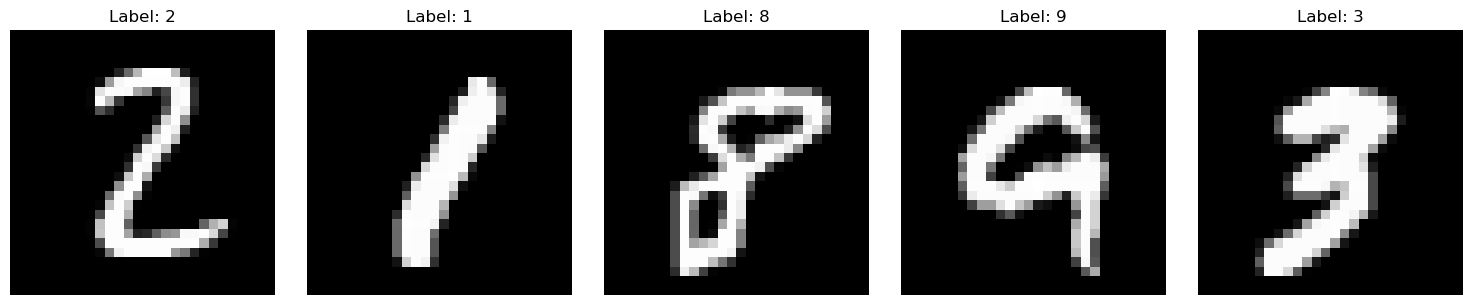

In [4]:
# Get current working directory
DATA_DIR = os.path.join(os.getcwd(), 'datasets', 'mnist')

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] range
])

dataset = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=DATA_DIR, train=False, transform=transform)

# Split training into training and validation
train_dataset, val_dataset = random_split(dataset, [50000, 10000])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128);

# Visaulize some samples from training set
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i, (image, label) in enumerate(train_loader):
    if i < 5:  # Print the first 5 samples
        plt.subplot(1, 5, i + 1)
        plt.imshow(image[0].squeeze(), cmap='gray')
        plt.title(f"Label: {label[0].item()}")
        plt.axis('off')
    else:
        break  # Exit the loop after printing 5 samples

plt.tight_layout()
plt.show()

### 1a. Model setup

In [6]:
latent_dim = 50
model = VAE(latent_dim=latent_dim).to(device)

### 1b. Model training

##### Define epochs and optimizer

In [7]:
epochs = 100
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model, train_losses, val_losses = train_vae(
    model,
    train_loader,
    val_loader,
    optimizer = optimizer,
    device = device,
    epochs=epochs,
    patience=None   # No early stopping
    )

Epoch 1, Training Loss (ELBO): 935.53, Validation Loss (ELBO): 1459.25
Epoch 2, Training Loss (ELBO): 1842.51, Validation Loss (ELBO): 2070.65
Epoch 3, Training Loss (ELBO): 2190.67, Validation Loss (ELBO): 2346.35
Epoch 4, Training Loss (ELBO): 2362.19, Validation Loss (ELBO): 2570.07
Epoch 5, Training Loss (ELBO): 2532.10, Validation Loss (ELBO): 2809.39
Epoch 6, Training Loss (ELBO): 2685.31, Validation Loss (ELBO): 2606.36
Epoch 7, Training Loss (ELBO): 2784.60, Validation Loss (ELBO): 3070.15
Epoch 8, Training Loss (ELBO): 2826.94, Validation Loss (ELBO): 3127.86
Epoch 9, Training Loss (ELBO): 2925.19, Validation Loss (ELBO): 3111.68
Epoch 10, Training Loss (ELBO): 2989.92, Validation Loss (ELBO): 2335.86
Epoch 11, Training Loss (ELBO): 3011.11, Validation Loss (ELBO): 2902.04
Epoch 12, Training Loss (ELBO): 3119.78, Validation Loss (ELBO): 3048.07
Epoch 13, Training Loss (ELBO): 3088.15, Validation Loss (ELBO): 3052.78
Epoch 14, Training Loss (ELBO): 3138.25, Validation Loss (ELB

#### Plot training and validation loss

In [ ]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('ELBO')  # clearer axis label
plt.title('ELBO vs Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("negative_elbo_curve.png", dpi=300)
plt.show()

NameError: name 'train_losses' is not defined

### 1c. Stopping criteria

In [35]:
patience = 5  # Early stopping criteria
epochs = 100
model, train_losses, val_losses = train_vae(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    epochs=epochs,
    patience=5  # Enable early stopping
)
torch.save(model.state_dict(), "best_model.pt")

Epoch 1, Training Loss (ELBO): 2275.79, Validation Loss (ELBO): 2418.83
Epoch 2, Training Loss (ELBO): 2301.15, Validation Loss (ELBO): 2356.98
Epoch 3, Training Loss (ELBO): 2242.37, Validation Loss (ELBO): 2280.16
Epoch 4, Training Loss (ELBO): 2342.48, Validation Loss (ELBO): 2034.17
Epoch 5, Training Loss (ELBO): 2276.84, Validation Loss (ELBO): 1968.18
Epoch 6, Training Loss (ELBO): 2280.09, Validation Loss (ELBO): 2391.08
Early stopping.


### 1d. Model testing

#### 1. Parameters of model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and load the model
model = VAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

# Generate Reconstruction Grid
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)[:32]
        x_recon, _, _, _, _ = model(x)
        x_recon = torch.clamp(x_recon, 0, 1)
        break

grid_original = vutils.make_grid(x.cpu(), nrow=8, pad_value=1)
grid_recon = vutils.make_grid(x_recon.cpu(), nrow=8, pad_value=1)

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].imshow(grid_original.permute(1, 2, 0), cmap='gray')
axs[0].axis('off')
axs[0].set_title("Original Test Images")

axs[1].imshow(grid_recon.permute(1, 2, 0), cmap='gray')
axs[1].axis('off')
axs[1].set_title("Reconstructed Images")

plt.tight_layout()
plt.savefig("reconstruction_grid.png", dpi=300)
plt.show()

#### 2. Drawing sample from q(Z|x)

In [39]:
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)[:32]
        mu, logvar = model.encoder(x)
        break
z = reparameterize(mu, logvar).to(device)

#### 3.  Parameters of the distribu p(X|z)

In [42]:
model.to(device)
mu_x, logvar_x = model.decoder(z)

#### 4. Sample an image x′ from p(X|z)

In [ ]:
model.eval()
with torch.no_grad():
    z = torch.randn(32, latent_dim).to(device)
    mu_x, logvar_x = model.decoder(z)
    x_sampled = reparameterize(mu_x, logvar_x)
    x_sampled = torch.clamp(x_sampled, 0, 1)

grid_samples = vutils.make_grid(x_sampled.cpu(), nrow=8, pad_value=1)

plt.figure(figsize=(8, 4))
plt.imshow(grid_samples.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title("Samples generated from Prior")
plt.tight_layout()
plt.savefig("samples_grid.png", dpi=300)
plt.show()